# Covid19 visualizations

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Feature set

### 1-1. Data prepare

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

import plotly.express as pex
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
pd.set_option("display.float_format", lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [5]:
patient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid_eda/data/PatientInfo.csv')
patient.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released


In [6]:
print(patient.shape, len(patient.patient_id.unique()))

(3388, 18) 3388


PatientInfo 내 3,388명의 확진자가 있는것으로 보여짐

In [7]:
data = patient.copy()

### 1-2. Infection route

어떤 경로로 코로나 바이러스에 감영되었는지 보여주는 특성입니다. 사람의 행동에 따라 값이 달라지므로 행동적인 특성으로 볼 수 있습니다.

In [8]:
print('unique values count of infection caase : ',len(data['infection_case'].unique()))
data['infection_case'].unique()

unique values count of infection caase :  24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

infections_case의 값의 종류가 24개인 것을 볼 수 있습니다. 24개의 값들이 실제로 얼마나 존재하는지 높은 순으로 정렬한 다음의 차트를 보면 첫 세개의 값(환자와의 직접 접촉-'contact with patient', 해외유입-'overseas inflow', 알수없음-'etc')을 제외한 나머지 각각은 큰 비중을 차지하지 않는 것을 볼 수 있습니다.

In [9]:
def drawinfectionValues(groups, feature):
  groups = data.groupby([feature])['patient_id'].count()
  groups = groups.reset_index()
  groups = groups.rename(columns = {'patient_id':'count'})
  groups = groups.sort_values('count', ascending=False)

  plt.figure(figsize=(10,8))
  plt.title('number of patients in infection_case values')
  sns.barplot(y=feature, x='count', data=groups)
  display()


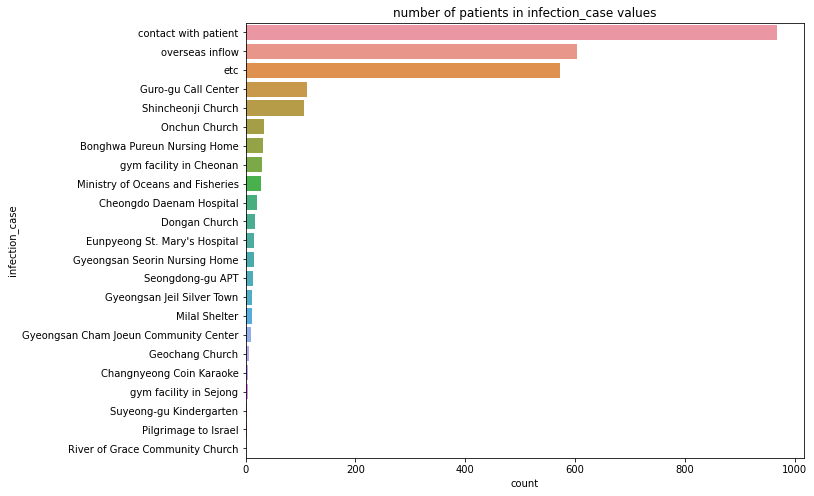

In [11]:
drawinfectionValues(data, 'infection_case')

'어디'에서 감염되었느냐를 보는 것이 분석의 목적이었다면, 모든 값의 사용을 고려하는 것이 맞을 것입니다. 하지만 이번 분석의 목적은 감염의 '어떤' 경로가 사망에 이르는 위험성을 가지고 있었느냐를 밝히는 것입니다. 그렇다면 '어디'라는 구체적 장소를 그대로 사용하는 것보다 이 변수를 활용해 '어떤' 방식으로 감염되게 되었는지를 만들어내 모델에 활용하는 것이 필요합니다. 첫 번째 세개의 값, '감염자와의 직접 접촉(contact with patient)', '해외유입(overseas inflow)', '알수없음(etc)'은 그 자체의 의미를 살려두고, 나머지는 집단 감염에 따른 세부적 사례를 나타내는 것으로 한데 묶어 '집단 감염(group)'의 값을 부여합니다.

하지만 이때 '집단 감염'을 정의하는데에는 주의를 필요로 합니다. 위의 차트를 보면 "River of Grace Community Church"는 교회에서 감염된 것으로 보아 '집단 감염'일 가능성이 있지만, 실제로 해당 값을 갖는 확진자는 단 한명에 불과합니다. 데이터 내에 한 명만이 존재하는 사례를 "집단 감염"이라고 보기는 어려울 것입니다. 마찬가지로 소수의 인원이 속한 값은 값 자체로는 집단으로 보일지 몰라도 실제로는 집단 감염이라고 보기 어렵습니다. 따라서 해당 값을 가진 확진자들의 수가 최소 5명 이상일 때에만 '집단 감염(group)' 값을 부여하고, 나머지는 활용하지 않습니다.

먼저 5명 미만의 infection_case를 추출해 확인합니다.

In [12]:
groups = data.groupby(['infection_case'])['patient_id'].count()
groups = pd.DataFrame(groups)

In [13]:
infection_case_less_5 = groups[groups['patient_id']<5].index.tolist()
groups[groups.index.isin(infection_case_less_5)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


5명 미만의 infection_case를 추출하여 14명의 확진자를 데이터에서 제거합니다.

In [14]:
print('original data shape:', data.shape)
data = data[~(data['infection_case'].isin(infection_case_less_5))]
print('removed data shape less than 5 infections :',data.shape)

original data shape: (3388, 18)
removed data shape less than 5 infections : (3374, 18)


infection_case 값에 존재하던 nan를 어떻게 처리할지를 결정합니다. 가장 간단한 방법은 nan값을 가진 확진자는 모두 제거하는 것일 겁니다. 하지만 아래 infection_csae의 nan의 수는 768개(약 23%)로 꽤 많은 비중을 차지하는 것을 볼 수 있습니다.

In [15]:
data[data['infection_case'].isna()].shape

(768, 18)

infection_case가 nan이라는 것은 그야말로 해당 확진자의 감염 경로를 "알 수 없다"는 의미이고, 해당 값은 infection_case의 값 중 하나인 etc가 의미하는 바와 같습니다. 따라서 nan은 etc와 같은 카테고리 - "알 수 없음(unknown)"으로 정의합니다.

In [16]:
def categorisation(x):
  if x == 'overseas inflow':
    y = 'overseas'
  elif x == 'contact with patient':
    y = 'individual'
  elif (x=='etc') | (pd.isna(x)):
    y = 'unknown'
  else:
    y = 'group'
  return y

In [17]:
data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))
print(data.shape)
data.head()



(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


새로 가공한 변수를 대상으로 다시 그려보면, 네 가지의 값이 모두 의미있는 분포를 보이는 것을 확인할 수 있으며 결과적으로도 의미있는 결과를 도출할 것이라고 예상할 수 있습니다.

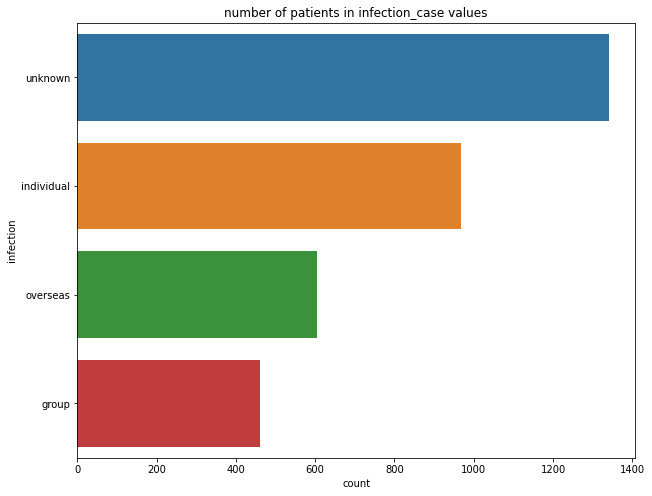

In [18]:
drawinfectionValues(groups, 'infection')

PatientInfo의 infection_case를 재가공하여 '집단감염(group)', '개인감염(individual)', '해외유입(overseas)', '밝혀지지않음(unknown)'으로 구성된 "감염 경로 유형"의 특성이 생성되었습니다.

### 1-3. Mobility level

유동성은 확진자들이 얼마만큼의 이동을 보였는지를 나타내는 특성입니다. 예를들어 친구를 만나러 카페에 간 사람과 가지 않고 집에 있던 사람은 유동성에서 다른 값을 갖게 될 것입니다. 따라서 유동성은 확진자들의 행동 유형을 구분지을 수 있는 행동적 특성의 하나로써 모델에 활용합니다. 유동성의 특성은 확진자들이 다녀갔던 장소에 대한 정보를 나타내는 PatientRoute의 type에 기반하여 생성됩니다.

In [19]:
route = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid_eda/data/PatientRoute.csv')
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [20]:
print('the number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

the number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [21]:
route[route['type'].isna()].shape

(0, 8)

먼저 데이터에는 총 24가지의 독립적인 장소들이 존재하고 있고, 해당 변수에는 결측치가 없는 것을 확인하였습니다. 이 장소들을 기반으로 각 확진자들의 '유동성'에 대한 특성을 추출합니다. 먼저 방문한 장소들을 기반으로 해당 이동이 필수적(essential)이었는지 부수적(non-essential)이었는지를 구분하고, 각 확진자 별로 필수적/부수적 이동을 얼마나 하였는지 그 횟수를 구합니다.

필수적/부수적 이동을 구별하고자 먼저 24가지의 장소들을 세부 카테고리로 구분하였습니다.

In [22]:
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon',
          'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

위 카테고리 중에서 '필수 교육(essential_edu)/필수 행정(essential_admin)/생활 필수(necessity)/의료(medical)' 카테고리를 필수적 이동(essential)으로 구분하고, 나머지는 부수적 이동(non-essential)으로 정의합니다.

In [23]:
essential = essential_edu + essential_admin + necessity + medical

In [24]:
def type_gorup_essential(x):
  group = None
  if x in essential:
    group = 'essential'
  else:
    group = 'non-essential'
  return group

In [25]:
route['route_group_essential'] = route['type'].apply(lambda x: type_gorup_essential(x))
route = route[['patient_id','type','route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [26]:
route['route_value'] = 1
groups = pd.DataFrame(route.groupby(['patient_id','route_group_essential'])['route_value'].count().unstack())
groups

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


간간이 nan의 값이 보이는 것을 볼 수 있습니다. raw data에서 type은 결측치가 없었고 위의 테이블은 이를 기반으로 essential/non-essential의 횟수를 구한 것으로, 위 테이블의 nan은 해당 확진자가 해당 이동(essential 또는 non-essential)을 하지 않았음을 의미합니다. 따라서 이 경우, nan의 값은 '이동을 하지 않았음'을 의미하는 0으로 채워줍니다.